In [1]:
using Gen
using Pkg
Pkg.activate("julia_by_example")
using Plots
using StatsPlots
using DelimitedFiles

  Activating project at `/gpfs/milgram/pi/yildirim/ilker/julia_by_example`


In [2]:
# helper function
function logmeanexp(scores)
    logsumexp(scores) - log(length(scores))
end;

## "Musical notes"

In [26]:
# helper functions to setup transition probabilities
function transition_prob(a, b)
    a == b ? 0.6 : 0.1
end

function transition_prob_matrix()
    note_transitions = Array{Float64}(undef, 5, 5)
    for i=1:5
        [note_transitions[i, j] = transition_prob(i,j) for j=1:5]
    end
    return note_transitions
end

global note_transitions = transition_prob_matrix()

5×5 Matrix{Float64}:
 0.6  0.1  0.1  0.1  0.1
 0.1  0.6  0.1  0.1  0.1
 0.1  0.1  0.6  0.1  0.1
 0.1  0.1  0.1  0.6  0.1
 0.1  0.1  0.1  0.1  0.6

In [34]:
@gen function musical_notes(K::Int)
    # sample an initial "note"
    current_note = {:notes => 1 => :x} ~ uniform_discrete(1, 5)
    # render it to "sensory features"
    mu = current_note * 0.1
    {:data => 1 => :y} ~ broadcasted_normal(repeat([mu], 5), repeat([0.01], 5))

    # keep going for K notes
    for k=1:K
        current_note = {:notes => k+1 => :x} ~ categorical(note_transitions[current_note, :])
        mu = current_note * 0.1
        {:data => k+1 => :y} ~ broadcasted_normal(repeat([mu], 5), repeat([0.05], 5))
    end 
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64], false, Union{Nothing, Some{Any}}[nothing], var"##musical_notes#311", Bool[0], false)

In [36]:
trace = simulate(musical_notes, (10,))
get_choices(trace)

notes = Vector{Int}(undef, 10)
features = Array{Float64}(undef, 10, 5)
[notes[k] = trace[:notes => k => :x] for k=1:10]
[features[k,:] = trace[:data => k => :y] for k=1:10]

10-element Vector{Vector{Float64}}:
 [0.29379500109888085, 0.3078633133970062, 0.2896548463916055, 0.30362074014955187, 0.2859679668539459]
 [0.34830170439165725, 0.3759297941907139, 0.28935539201064225, 0.27779654578143, 0.2950535696955653]
 [0.31010094548160194, 0.27653512381772793, 0.26797891950949565, 0.2415822556558942, 0.23459184080529621]
 [0.34032106378399096, 0.31072198681374236, 0.2531056514926268, 0.2488444749919943, 0.3458121208797179]
 [0.3450689513478571, 0.416793789348665, 0.3135878391959148, 0.32004803240406304, 0.43194839181753697]
 [0.32952609168457264, 0.3780753865042595, 0.27929582577224127, 0.2676335665823253, 0.28583725592123316]
 [0.18452987569697554, 0.2555745915396837, 0.29196984535002785, 0.28580118365190277, 0.3539561005743848]
 [0.2382329642364304, 0.21537696388025268, 0.3075019497665494, 0.26222689276808864, 0.2903234439226864]
 [0.2965415394612144, 0.22329933843535246, 0.280227077384417, 0.2421707386443728, 0.332905656204204]
 [0.2483847251613816, 0.299857

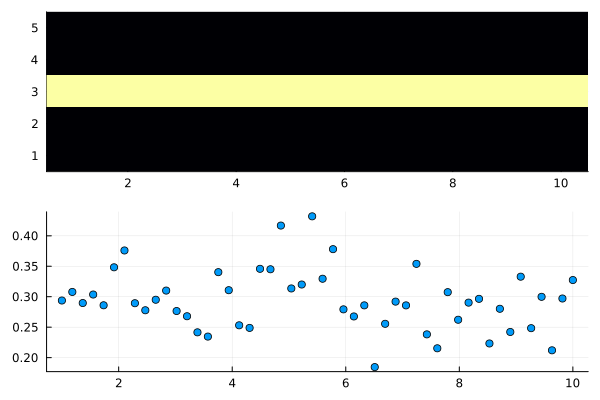

In [41]:
function visualize_notes(notes::Vector{Int}, features)
    K = length(notes)
    binary_notes = zeros(Int, 5, K)
    for k = 1:K
        binary_notes[notes[k], k] = 1
    end
    p1 = plot(binary_notes, seriestype=:heatmap, legend=:none)
    features = collect(Iterators.flatten(transpose(features)))
    p2 = plot(collect(range(1, K, length=5*K)), features, seriestype=:scatter)
    plot(p1, p2, layout=(2,1), legend=false)
end
#writedlm("notes_observe.txt", features)
visualize_notes(notes, features)

In [37]:
function particle_filter(num_particles::Int, zs::Matrix{Float64}, num_samples::Int)
    # construct initial observations
    init_obs = Gen.choicemap((:data => 1 => :y, zs[1,:]))

    # initialize the particle filter (Step 0)
    state = Gen.initialize_particle_filter(musical_notes, (0,), init_obs, num_particles)
    
    for k=1:size(zs)[1]-1
        # Evolve and resample (Step 1a, 1b)
        maybe_resample!(state, ess_threshold=num_particles/2)
        # load observations of this time step
        obs = Gen.choicemap((:data => k+1 => :y, zs[k+1,:]))
        # Re-weight by the likelihood (Step 2)
        Gen.particle_filter_step!(state, (k,), (UnknownChange(),), obs)
    end
    
    # return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end;

In [43]:
# load observations (sensory features)
zs = readdlm("notes_observe.txt")

# run particle filter with 1000 particles, 
# and return 100 unweighted posterior samples
pf_traces = particle_filter(1000, zs, 100);

In [56]:
function visualize_notes(notes::Matrix{Float64}, features)
    K = size(notes)[2]
    p1 = plot(notes, seriestype=:heatmap)
    features = collect(Iterators.flatten(transpose(features)))
    p2 = plot(collect(range(1, K, length=5*K)), features, seriestype=:scatter)
    plot(p1, p2, layout=(2,1), legend=false)
end

visualize_notes (generic function with 3 methods)

Log probability: 62.92792206904091


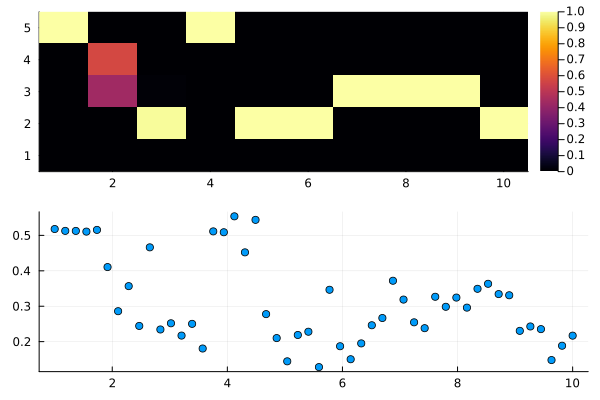

In [57]:
scores = Vector{Float64}(undef, 100)
inferred_notes = zeros(Int, 100, 10)
aggregate_notes_matrix = zeros(Float64, 5, 10)
for i=1:100
    tr = pf_traces[i]
    scores[i] = get_score(tr)
    for k = 1:size(zs)[1]
        inferred_notes[i, k] = tr[:notes => k => :x]
        aggregate_notes_matrix[inferred_notes[i, k], k] += 1.0
    end
end

aggregate_notes_matrix = aggregate_notes_matrix ./ 100
println("Log probability: ", logmeanexp(scores))
visualize_notes(aggregate_notes_matrix, zs)

In [12]:
using Statistics
mean(inferred_notes, dims=1)

1×10 Matrix{Float64}:
 5.0  3.79  2.02  5.0  2.0  2.0  3.0  3.0  3.0  2.01

### Using Unfold for the Generative Model

In [ ]:
@gen function kernel_musical_notes(k::Int, prev_note)
    # draw the note
    current_note = {:note} ~ categorical(nextnote[prev_note, :])
    # draw the sensory features
    mu = current_note * 0.1
    {:data} ~ broadcasted_normal(repeat([mu], 5), repeat([0.05], 5))
    
    #return the current note for recursion
    return current_note
end

@gen function unfold_musical_notes(K::Int)    
    # sample an initial "note"
    init_note = uniform_discrete(1, 5)
    # call the temporal kernel and unfold it for K time steps
    music ~ Unfold(kernel_musical_notes)(K, init_note)

end
trace = simulate(unfold_musical_notes, (10,))
get_choices(trace)
notes = Vector{Int}(undef, 10)
features = Array{Float64}(undef, 10, 5)
[notes[k] = trace[:music => k => :note] for k=1:10]
[features[k,:] = trace[:music => k => :data] for k=1:10]

## Change point model

In [13]:
 uniform_discrete(1, 5)

3

In [14]:
struct State
    r::Int
    lambda::Float64
end

In [15]:
@gen function change_point_kernel(k::Int, prev_state::State, rate_weight::Float64)

    # did a change occur?
    change ~ bernoulli(rate_weight)

    # keep count of run length
    r = (change || k == 1) ? 0 : prev_state.r + 1

    # draw the intensity parameter accordingly
    if r == 0
        lambda ~ gamma(2, 1)
    else
        lambda = prev_state.lambda
    end
    
    # draw the observed counts
    y ~ poisson(lambda)
    
    new_state = State(r, lambda)
    return new_state
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, State, Float64], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##change_point_kernel#299", Bool[0, 0, 0], false)

In [16]:
@gen function change_point(k::Int=50, rate::Float64=25.0)

    # "run time" length prior
    rate_weight ~ exponential(rate)
    init_state = State(0, 0.)
    
    data ~ Unfold(change_point_kernel)(k, init_state, rate_weight)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Float64], true, Union{Nothing, Some{Any}}[Some(50), Some(25.0)], var"##change_point#300", Bool[0, 0], false)

In [17]:
(trace, _) = generate(change_point, ()) 
get_choices(trace)

│
├── :rate_weight : 0.03943710259118852
│
└── :data
    │
    ├── 1
    │   │
    │   ├── :lambda : 1.7608249577841981
    │   │
    │   ├── :change : false
    │   │
    │   └── :y : 2
    │
    ├── 2
    │   │
    │   ├── :change : false
    │   │
    │   └── :y : 1
    │
    ├── 3
    │   │
    │   ├── :change : false
    │   │
    │   └── :y : 0
    │
    ├── 4
    │   │
    │   ├── :change : false
    │   │
    │   └── :y : 3
    │
    ├── 5
    │   │
    │   ├── :change : false
    │   │
    │   └── :y : 0
    │
    ├── 6
    │   │
    │   ├── :change : false
    │   │
    │   └── :y : 1
    │
    ├── 7
    │   │
    │   ├── :change : false
    │   │
    │   └── :y : 1
    │
    ├── 8
    │   │
    │   ├── :change : false
    │   │
    │   └── :y : 1
    │
    ├── 9
    │   │
    │   ├── :change : false
    │   │
    │   └── :y : 1
    │
    ├── 10
    │   │
    │   ├── :change : false
    │   │
    │   └── :y : 4
    │
    ├── 11
    │   │
    │   ├── :change : false
    │   │


In [18]:
function unfold_particle_filter(num_particles::Int, observations::Vector{Int}, num_samples::Int)
    
    init_obs = Gen.choicemap((:data => 0 => :y, 0))
    
    state = Gen.initialize_particle_filter(change_point, (0,), init_obs, num_particles)
    
    for k=1:length(zs)-1
        maybe_resample!(state, ess_threshold=num_particles/2)
        obs = Gen.choicemap((:data => k => :y, zs[k]))
        Gen.particle_filter_step!(state, (k,), (UnknownChange(),), obs)
    end

    return Gen.sample_unweighted_traces(state, num_samples)
end

unfold_particle_filter (generic function with 1 method)

In [19]:
zs = round.(Int, readdlm("count_data.txt")[:])

unfold_pf_traces = unfold_particle_filter(1000, zs, 100);

Log probability: -76.40622443643845


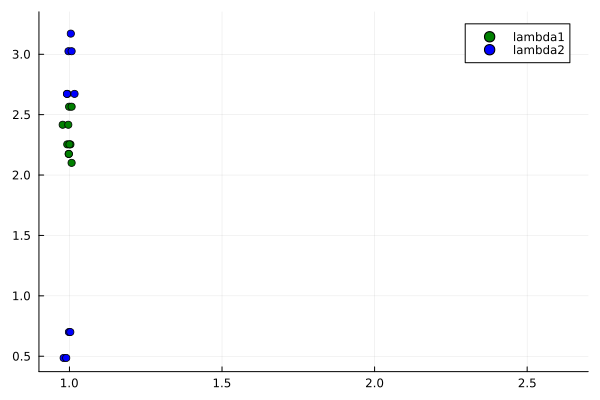

In [20]:
scores = Vector{Float64}(undef, 100)
inferred_lambda = zeros(Float64, 100, 2)
inferred_n = Vector{Int}(undef, 100)
for i=1:100
    tr = unfold_pf_traces[i]
    scores[i] = get_score(tr)
    inferred_lambda[i,1] = tr[:data=>1=>:lambda]
    for k = 1:length(zs)
        if tr[:data=>k=>:change]
            inferred_n[i] = k
            inferred_lambda[i,2] = tr[:data=>k=>:lambda]
            break
        end
    end
end
println("Log probability: ", logmeanexp(scores))
plot(repeat([1], 10) + 0.01*randn(10), inferred_lambda[:,1],  seriestype=:scatter, label="lambda1", color="green")
plot!(repeat([1], 10) + 0.01*randn(10), inferred_lambda[:,2], seriestype=:scatter, label="lambda2", color="blue")
xlims!(0.9, 2.7)

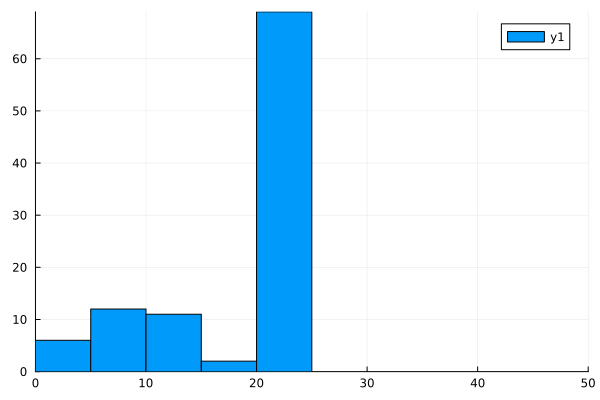

In [21]:
plot(inferred_n, seriestype=:histogram)
xlims!((0, length(zs)))